# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Barges

<img src="Figures/system_layout_alternative_2B.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
# %matplotlib inline
%matplotlib notebook

import seaborn as sns
sns.set(style="ticks")
# sns.set_style("whitegrid")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_barge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# 
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# scroll_to_current_cell(preserve=True)

In [3]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000),
             ('New-Panamax (12,500 TEU)', 12500),
             ('ULCS (21,000 TEU)', 21000)],
    value=12500,
    description='OGV:')

barge = widgets.Dropdown(
    options=[('Small (200 TEU)', 200),
             ('Medium (250 TEU)', 250),
             ('Large (300 TEU)', 300)],
    value=250,
    description='Barge:')

life_cycle = widgets.IntSlider(
    value=10, min=10, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('\033[1m*** Input Values \033[0m')
display(annual_demand, offshore_onshore_distance, container_ship, barge, life_cycle)

*** Input Values 


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

IntSlider(value=10, description='Life cycle:', max=30, min=10, step=5)

In [4]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

11


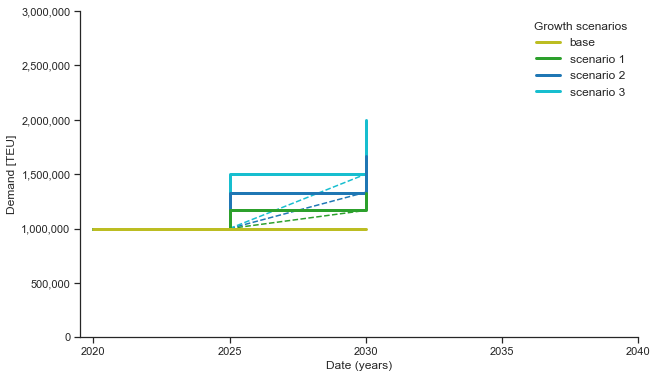

In [5]:
container = demand  # TEU
years = list(range(startyear, startyear+lifecycle+1))
print(len(years))
trend_1 = []
trend_2 = []
trend_3 = []

for i in range(lifecycle-4):
    trend_1.append(container +   500_000/15 * i)
    trend_2.append(container + 1_000_000/15 * i)
    trend_3.append(container + 1_500_000/15 * i)

demand_0 = []
demand_1 = []
demand_2 = []
demand_3 = []

for year in years:
    if year < 2025:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.00))
        demand_3.append(int(container * 1.00))
        
    elif year < 2030:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.17))
        demand_2.append(int(container * 1.33))
        demand_3.append(int(container * 1.50))
    elif year < 2035:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.33))
        demand_2.append(int(container * 1.67))
        demand_3.append(int(container * 2.00))
    else:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.50))
        demand_2.append(int(container * 2.00))
        demand_3.append(int(container * 2.50))

# figure 
plt.figure(figsize=(10,6))

plt.plot(years[5:lifecycle+1], trend_1, color='tab:green', linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_2, color='tab:blue' , linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_3, color='tab:cyan' , linestyle='--', zorder=0)

plt.step(years, demand_0, color='tab:olive', linewidth=3, label='base', where='post', zorder=4)
plt.step(years, demand_1, color='tab:green', linewidth=3, label='scenario 1', where='post', zorder=3)
plt.step(years, demand_2, color='tab:blue' , linewidth=3, label='scenario 2', where='post', zorder=2)
plt.step(years, demand_3, color='tab:cyan' , linewidth=3, label='scenario 3', where='post', zorder=1)

plt.xticks([2020, 2025, 2030, 2035, 2040])
plt.xlabel("Date (years)", fontsize='large')

plt.yticks([0, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6],
           [0, '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000'])
plt.ylabel('Demand [TEU]', fontsize='large')

plt.legend(loc='best', title='Growth scenarios', title_fontsize='large', fontsize='large', frameon=False)

# figure aesthetics
plt.grid(False, which='major')
sns.despine(top=True)

# save fig
if life_cycle == 20:
    plt.savefig("SaveFigures/growth_scenarios.png")

In [6]:
if lifecycle == 20:
    years = years[0:20]
    demand_0 = demand_0[0:20]
    demand_1 = demand_1[0:20]
    demand_2 = demand_2[0:20]
    demand_3 = demand_3[0:20]
    
if lifecycle == 10:
    years = years[0:10]
    demand_0 = demand_0[0:10]
    demand_1 = demand_1[0:10]
    demand_2 = demand_2[0:10]
    demand_3 = demand_3[0:10]

print('Years:', len(years), years)    
print('Demand:',len(demand_2), demand_2)

Years: 10 [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029]
Demand: 10 [1000000, 1000000, 1000000, 1000000, 1000000, 1330000, 1330000, 1330000, 1330000, 1330000]


In [7]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand_3}
print(scenario_data)

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
# print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container)
# print(container.scenario_data)

# combine
demand = [container]

{'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029], 'volume': [1000000, 1000000, 1000000, 1000000, 1000000, 1500000, 1500000, 1500000, 1500000, 1500000]}


## 0.2 Generate vessels

In [8]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [9]:
OffshoreBarge = container_system_offshore_barge.System(
                startyear = startyear,
                lifecycle = lifecycle,
                stack_equipment = 'rmg',
                laden_stack = 'rmg',
                elements = demand + vessels,
                crane_type_defaults = container_defaults.sts_crane_data,
                offshore_distance = offshore_distance,
                barge_type = 'medium',
                bathymetry_factor = 0.80,
                allowable_berth_occupancy = 0.70,
                laden_perc=0.80, 
                reefer_perc=0.10,
                empty_perc=0.05, 
                oog_perc=0.05,
                transhipment_ratio = 0.0,
                debug = True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, {revenues})
    7. calculate PV's {and aggregate to NPV}

In [10]:
OffshoreBarge.simulate()


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

*** nr of berths: 1
quay_length_in_func 430 m
quay_depth 17 m
  *** add Quay to elements
df    Year  Offshore Terminal 

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2028: FutureWarning:

`item` has been deprecated and will be removed in a future version




     Berth occupancy planned (after adding Quay): 0.741
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021               11500000.0            1.916667e+07   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  Offshore Insurance  \
0                   0.0             0.000000                 0.0   
1                   0.0             0.000000                 0.0   
2              200000.0        333333.333333            100000.0   
3              200000.0        333333.333333            100000.0   
4              200000.0        333333.333333            100000.0   

   Onshore Insurance  Offshore Labour  Onshore Labour  
0           0.000000       

4               73440.0             122400.0  
  *** add Empty Stack to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                 759400.0            1.265667e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2               73440.0             122400.0  
3               73440.0             122400.0  
4               73440.0             122400.0  
  *** add Empty Stack to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                 759400.0            1.265667e+06   
2  2022                      0.0            0.000000e+00

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2539: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2104: FutureWarning:

`item` has been deprecated and will be removed in a future version



df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                1705000.0            2.841667e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2              168000.0             280000.0  
3              168000.0             280000.0  
4              168000.0             280000.0  
  *** add OOG stack to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                1705000.0            2.841667e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024            

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                4938495.0            8.230825e+06   
1  2021                3292330.0            5.487217e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  Offshore Insurance  \
0                   0.0                  0.0                 0.0   
1                   0.0                  0.0                 0.0   
2               45027.0              75045.0             45027.0   
3               45027.0              75045.0             45027.0   
4               45027.0              75045.0             45027.0   

   Onshore Insurance  
0                0.0  
1                0.0  
2            75045.0  
3            75045.0  
4            75045.0  
     Offshore barge berth capacity planned     (@ start of year): 142156.1 [TEU/yr]
     

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                 505000.0           841666.666667   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2               10000.0         16666.666667    144230.769231   240384.615385  
3               10000.0         16666.666667    144230.769231   240384.615385  
4               10000.0         16666.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                 505000.0           841666.666667   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2               10000.0         16666.666667    144230.769231   240384.615385  
3               10000.0         16666.666667    144230.769231   240384.615385  
4               10000.0         16666.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                 505000.0           841666.666667   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2               10000.0         16666.666667    144230.769231   240384.615385  
3               10000.0         16666.666667    144230.769231   240384.615385  
4               10000.0         16666.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021   19000000.0         0.0
2  2022          0.0   1900000.0
3  2023          0.0   1900000.0
4  2024          0.0   1900000.0
barges_online 20
length 100
draught 5.0
beam 13.0
  *** add Barge Channel to elements

Calibration Barge Channel
barge_channel_width 127 m
barge_channel_depth 8 m
barge_channel_length 24,000 m
barge_channel_volume 12,230,399 m3
barge_turning_circle_diameter 180 m
barge_turning_circle_volume 203,575 m3
barge_berth_pocket_width 26 m
barge_berth_pocket_volume 235,040 m3
barge_dredging_volume 12,669,015 m3
df    Year  Capital Dredging  Maintenance Dredging
0  2020        79181345.0          0.000000e+00
1  2021        79181345.0          0.000000e+00
2  2022               0.0          5.701057e+06
3  2023               0.0          5.701057e+06
4  2024               0.0          5.701057e+06

     Onshore barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Onshore barge berth 

   > Throughput online 1000000 TEU per year
     Horizontal Transport online (@ start of year): 0
     Number of STS cranes        (@ start of year): 7

  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                  86000.0           143333.333333   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2                8500.0         14166.666667    144230.769231   240384.615385  
3                8500.0         14166.666667    144230.769231   240384.615385  
4                8500.0         14166.666667    14423

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                  86000.0           143333.333333   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2                8500.0         14166.666667    144230.769231   240384.615385  
3                8500.0         14166.666667    144230.769231   240384.615385  
4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                  86000.0           143333.333333   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2                8500.0         14166.666667    144230.769231   240384.615385  
3                8500.0         14166.666667    144230.769231   240384.615385  
4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                2505000.0               4175000.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0             0.000000  
1                   0.0             0.000000  
2              250000.0        416666.666667  
3              250000.0        416666.666667  
4              250000.0        416666.666667  
  *** add Stack Equipment to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                2505000.0               4175000.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024      

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Insurance  \
0                   0.0                  0.0                 0.0   
1                   0.0                  0.0                 0.0   
2                   0.0                  0.0                 0.0   
3                   0.0                  0.0                 0.0   
4                   0.0                  0.0                 0.0   

   Onshore Insurance  Offshore Labour  Onshore Labour  
0                0.0              0.0             0.0  
1                0.0              0.0             0.0  
2                0.0              0.0             0.0  
3  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0                  0.0              0.0             0.0  
1                   0.0                  0.0              0.0             0.0  
2                   0.0                  0.0              0.0             0.0  
3                   0.0                  0.0              0.0             0.0  
4                   0.0                  0.0              0.0             0.0  
  *** add Gate to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  202

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0                  0.0              0.0             0.0  
1                   0.0                  0.0              0.0             0.0  
2                   0.0                  0.0              0.0             0.0  
3                   0.0                  0.0              0.0             0.0  
4                   0.0                  0.0              0.0             0.0  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  

df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021          0.0         0.0
2  2022          0.0         0.0
3  2023          0.0         0.0
4  2024          0.0         0.0
barges_online 30
length 100
draught 5.0
beam 13.0

     Onshore barge berth capacity planned     (@ start of year): 852940.0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 852940.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.319 [-]
     Onshore barge berth capacity required    (@ start of year): 1125000.0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 995090.0 TEU
     Onshore barge berth capacity online  (after adding Berth): 852940.0 TEU

*** nr of onshore barge berths: 7
  *** add Onshore Barge Quay to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                    

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0                  0.0              0.0             0.0  
1                   0.0                  0.0              0.0             0.0  
2                   0.0                  0.0              0.0             0.0  
3                   0.0                  0.0              0.0             0.0  
4                   0.0                  0.0              0.0             0.0  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2                   0.0                  0.0  
3                   0.0                  0.0  
4                   0.0                  0.0  
  *** add Stack Equipment to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024      

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0                  0.0              0.0             0.0  
1                   0.0                  0.0              0.0             0.0  
2                   0.0                  0.0              0.0             0.0  
3                   0.0                  0.0              0.0             0.0  
4                   0.0                  0.0              0.0             0.0  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:503: FutureWarning:

`item` has been deprecated and will be removed in a future version



container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 90,000,000 USD
container_ship_costs 90,000,000 USD
container_ship_costs 90,000,000 USD
container_ship_costs 90,000,000 USD
container_ship_costs 90,000,000 USD


## 3. Report all elements

In [11]:
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1500000
6  2026  1500000
7  2027  1500000
8  2028  1500000
9  2029  1500000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '9e9c44d8-5e38-11ea-bc48-0050b68868ee'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'avg_transport_costs': 2128, 'year_purchase': [], 'year_online': [], 'name': 'Fully_Cellular_1', 'id': '9e9d7dcc-5e38-11ea-8ee0-0050b68868ee'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes'

{'land_use': [], 'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': [], 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'barge_berth', 'ownership': 'Terminal operator', 'delivery_time': 2, 'lifespan': 50, 'unit_rate': 30000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'nom_crane_productivity': 15.0, 'utilisation': 0.9, 'efficiency': 0.75, 'crane_per_berth': 1.3, 'handling_time_ratio': 0.9, 'peak_factor': 1.1, 'year_purchase': [], 'year_online': 2022, 'name': 'Barge_Berth', 'id': '9f6df7dc-5e38-11ea-a1cb-0050b68868ee'}

Quay

{'land_use': 9726.749999999996, 'triggers': [], 'renevu

{'triggers': [], 'labour': 144230.76923076922, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': 86000, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2026, 'name': 'Tractor-trailer', 'id': 'a04effd1-5e38-11ea-a1c3-0050b68868ee', 'shift': 5.769230769230769, 'df':  

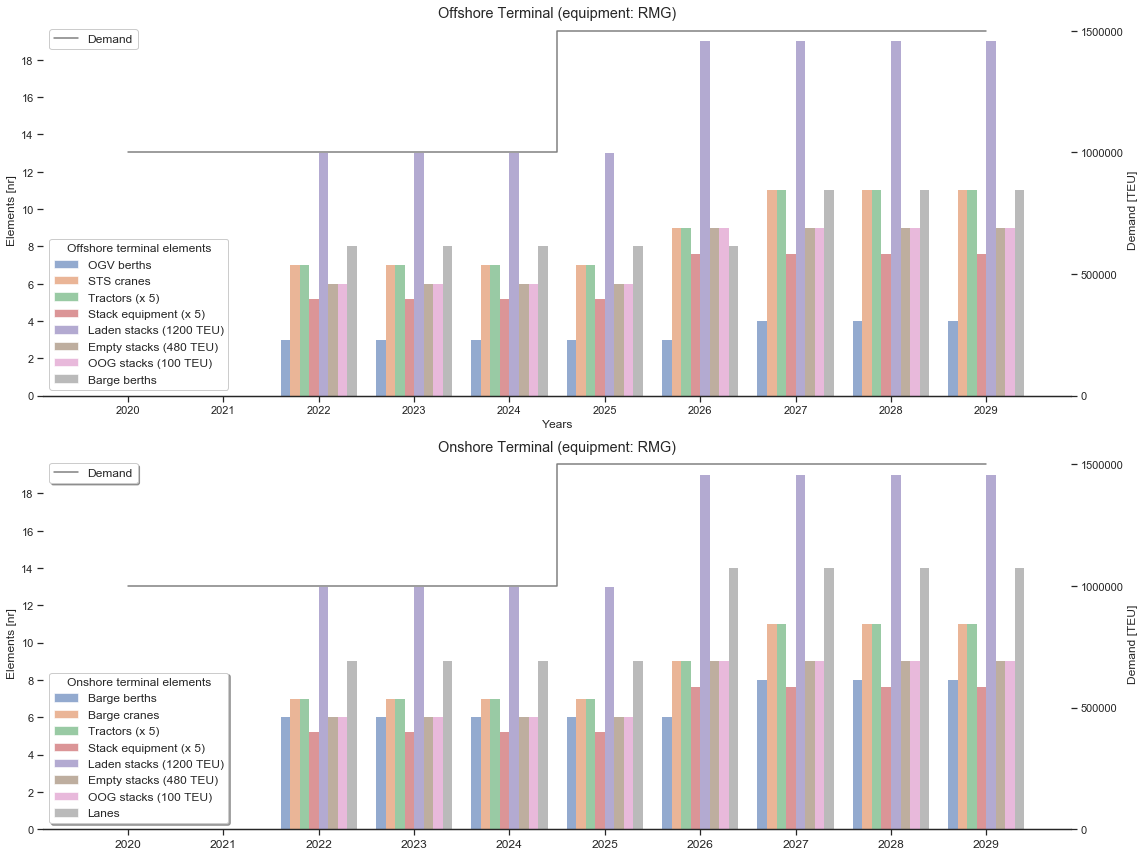

In [12]:
OffshoreBarge.terminal_elements_plot()
sns.despine(left=True)
# print(scenario_data)

# save fig
if lifecycle == 10:
    plt.savefig("SaveFigures/terminal_elements_alt2_example.png", bbox_inches = 'tight')
if lifecycle == 20:
    plt.savefig("SaveFigures/terminal_elements_alt2.png", bbox_inches = 'tight')

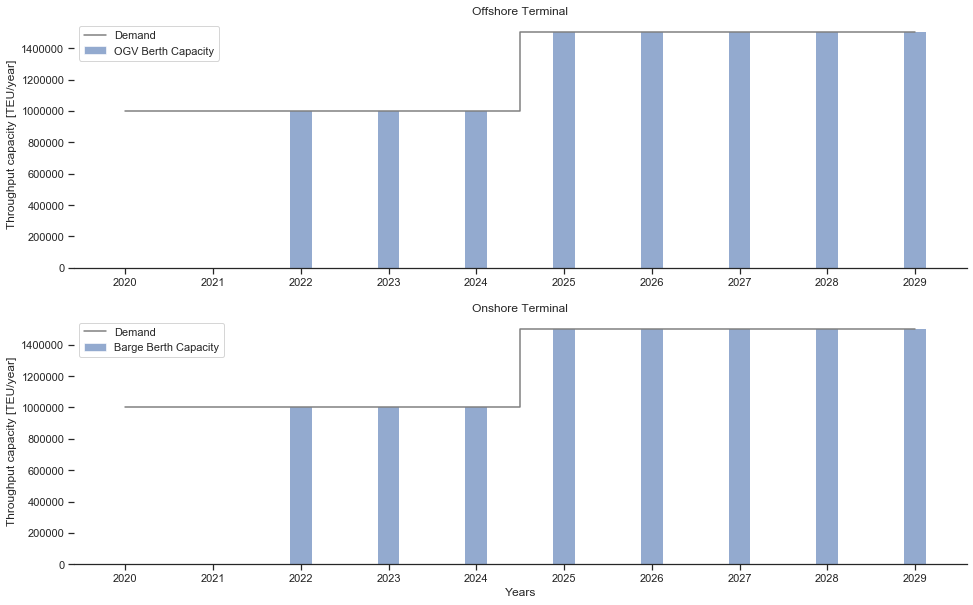

In [13]:
OffshoreBarge.terminal_capacity_plot()
sns.despine(left=True)

,Laden stack (ha),OOG stack (ha),Empty stack (ha),Total storage (ha),Total land use (ha)
Year,,,,,
2020,0.000000,0.000,0.00000,0.000000,0.000000
2021,0.000000,0.000,0.00000,0.000000,0.000000
2022,16.251862,4.032,1.76256,22.046422,39.558047
2023,16.251862,4.032,1.76256,22.046422,39.558047
2024,16.251862,4.032,1.76256,22.046422,39.558047
2025,16.251862,4.032,1.76256,22.046422,39.558047
2026,23.752721,6.048,2.64384,32.444561,49.956186
2027,23.752721,6.048,2.64384,32.444561,55.864286
2028,23.752721,6.048,2.64384,32.444561,55.864286


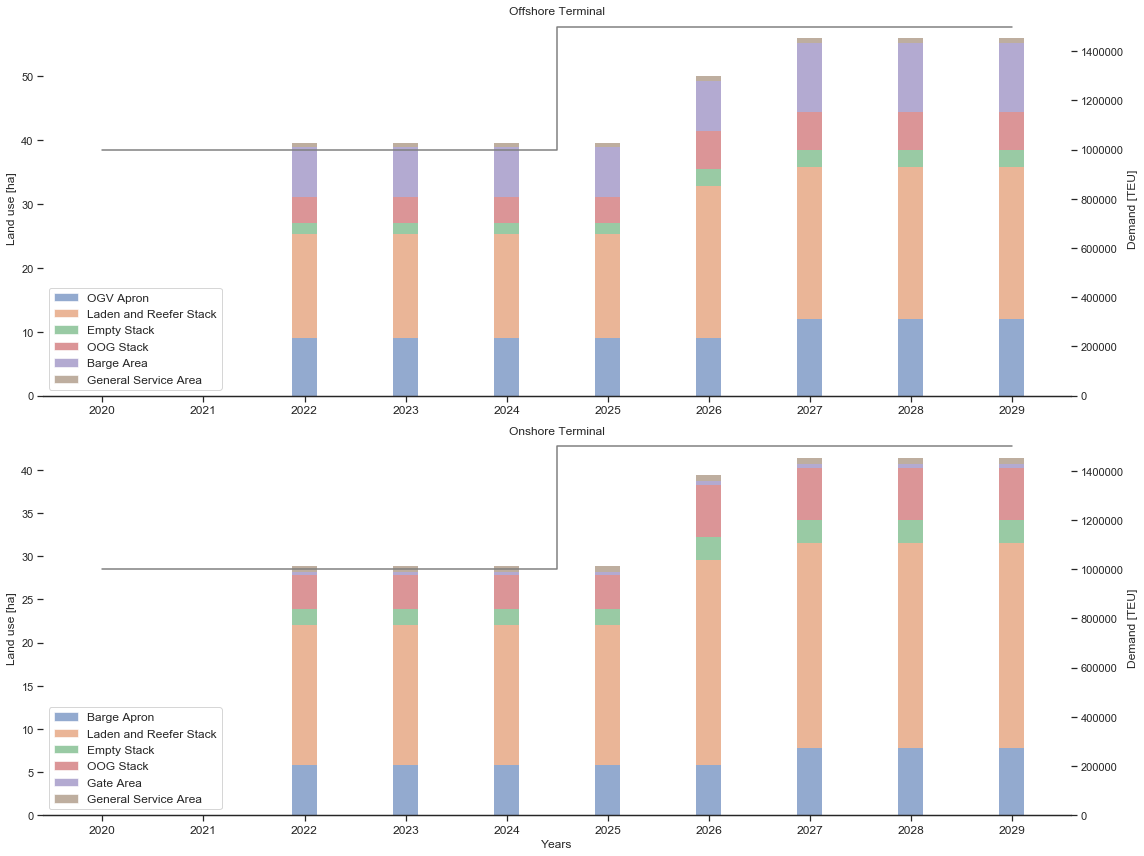

In [14]:
scroll_to_current_cell(preserve=True)

OffshoreBarge.terminal_land_use_plot()
sns.despine(left=True)

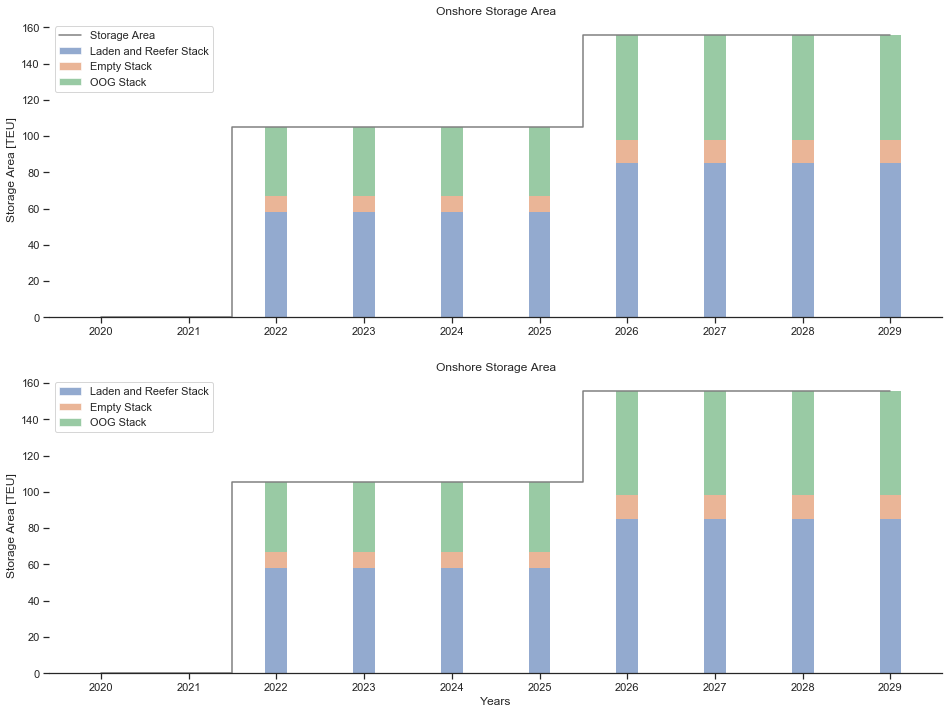

In [15]:
OffshoreBarge.storage_area_plot()
sns.despine(left=True)

# save fig
plt.savefig("SaveFigures/storage_area_ex2.png")

#### Add cash flow information for each of the terminal elements.

In [16]:
cash_flows_df, cash_flows_WACC_real_df = OffshoreBarge.add_cashflow_elements()
display(cash_flows_df.style.hide_index())

Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Terminal Capex,Offshore Maintenance,Offshore Insurance,Offshore Energy,Offshore Labour,Offshore Fuel,Offshore Terminal Opex,Onshore Terminal Capex,Onshore Maintenance,Onshore Insurance,Onshore Energy,Onshore Labour,Onshore Fuel,Onshore Terminal Opex,Ocean Transport,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging
2020,4.5e+07,2.73e+08,0,1.45883e+08,0,0,0,0,0,0,2.43139e+08,0,0,0,0,0,0,0,0,0,2.6313e+08,0
2021,6.75e+07,4.095e+08,0,3.60745e+08,0,0,0,0,0,0,6.01242e+08,0,0,0,0,0,0,0,1.9e+08,0,2.6313e+08,0
2022,0,0,4.1295e+06,0,1.62883e+07,2.42404e+06,0,1.7899e+07,0,0,0,2.71472e+07,4.04007e+06,0,2.98317e+07,0,0,0,0,1.9e+07,0,1.89453e+07
2023,0,0,4.1295e+06,0,1.62883e+07,2.42404e+06,0,1.7899e+07,0,0,0,2.71472e+07,4.04007e+06,0,2.98317e+07,0,0,0,0,1.9e+07,0,1.89453e+07
2024,0,0,4.1295e+06,0,1.62883e+07,2.42404e+06,0,1.7899e+07,0,0,0,2.71472e+07,4.04007e+06,0,2.98317e+07,0,0,0,0,1.9e+07,0,1.89453e+07
2025,0,0,4.1295e+06,1.44414e+08,1.62883e+07,2.42404e+06,0,1.7899e+07,0,0,2.4069e+08,2.71472e+07,4.04007e+06,0,2.98317e+07,0,0,0,2.45e+08,1.9e+07,0,1.89453e+07
2026,0,0,4.1295e+06,5.73683e+07,2.25759e+07,2.62404e+06,0,2.50625e+07,0,0,9.56139e+07,3.76264e+07,4.3734e+06,0,4.17708e+07,0,0,0,0,4.35e+07,0,1.89453e+07
2027,0,0,4.1295e+06,0,2.36504e+07,3.41358e+06,0,2.80913e+07,0,0,0,3.94173e+07,5.6893e+06,0,4.68189e+07,0,0,0,0,4.35e+07,0,1.89453e+07
2028,0,0,4.1295e+06,0,2.36504e+07,3.41358e+06,0,2.80913e+07,0,0,0,3.94173e+07,5.6893e+06,0,4.68189e+07,0,0,0,0,4.35e+07,0,1.89453e+07
2029,0,0,4.1295e+06,0,2.36504e+07,3.41358e+06,0,2.80913e+07,0,0,0,3.94173e+07,5.6893e+06,0,4.68189e+07,0,0,0,0,4.35e+07,0,1.89453e+07


In [17]:
(island_construction, coastal_protection_construction, offshore_maintenance,
 off_terminal_capex, terminal_opex, capital_dredging, maintenance_dredging, 
 ocean_transport, barge_capex, barge_opex, cash_flows, cash_flows_df, cash_flows_WACC_real_df, PV
 ) = OffshoreBarge.net_present_value()

In [18]:
# OffshoreBarge.terminal_opex_plot(cash_flows_df)
# sns.despine(left=True)

In [19]:
print('\033[1m    Financial Indication\033[0m')
print(' ** PV of the costs: ${}'.format(f'{round(PV,-6):,}'))

hide_columns_list = ['Offshore Maintenance', 'Offshore Insurance', 'Offshore Energy', 
                     'Offshore Labour', 'Offshore Fuel', 'Offshore Demurrage',
                     'Onshore Maintenance', 'Onshore Insurance', 'Onshore Energy', 
                     'Onshore Labour', 'Onshore Fuel', 'Onshore Demurrage']
cash_flows_WACC_real_df.style.hide_columns(hide_columns_list).hide_index()

    Financial Indication
 ** PV of the costs: $-2,843,000,000.0


c:\users\hugo stam\anaconda3\envs\offshoreterminals\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Terminal Capex,Offshore Terminal Opex,Onshore Terminal Capex,Onshore Terminal Opex,Ocean Transport,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging,Total
2020,4.5e+07,2.73e+08,0,1.45883e+08,0,2.43139e+08,0,0,0,0,2.6313e+08,0,7.27013e+08
2021,6.36557e+07,3.86178e+08,0,3.402e+08,0,5.67e+08,0,0,1.79179e+08,0,2.48144e+08,0,1.21736e+09
2022,0,0,3.67252e+06,0,3.25599e+07,0,0,0,0,1.68974e+07,0,1.68488e+07,6.99787e+07
2023,0,0,3.46336e+06,0,3.07055e+07,0,0,0,0,1.59351e+07,0,1.58892e+07,6.59932e+07
2024,0,0,3.26611e+06,0,2.89568e+07,0,0,0,0,1.50275e+07,0,1.49843e+07,6.22347e+07
2025,0,0,3.0801e+06,1.07715e+08,2.73076e+07,1.79525e+08,0,0,1.8274e+08,1.41717e+07,0,1.41309e+07,3.49145e+08
2026,0,0,2.90468e+06,4.03527e+07,3.53545e+07,6.72546e+07,0,0,0,3.05978e+07,0,1.33261e+07,1.22536e+08
2027,0,0,2.73925e+06,0,3.65866e+07,0,0,0,0,2.88552e+07,0,1.25671e+07,8.07482e+07
2028,0,0,2.58324e+06,0,3.45029e+07,0,0,0,0,2.72118e+07,0,1.18514e+07,7.61493e+07
2029,0,0,2.43612e+06,0,3.25379e+07,0,0,0,0,2.5662e+07,0,1.11764e+07,7.18124e+07


 Cash Flow Plot - Weighted average cost of capital 


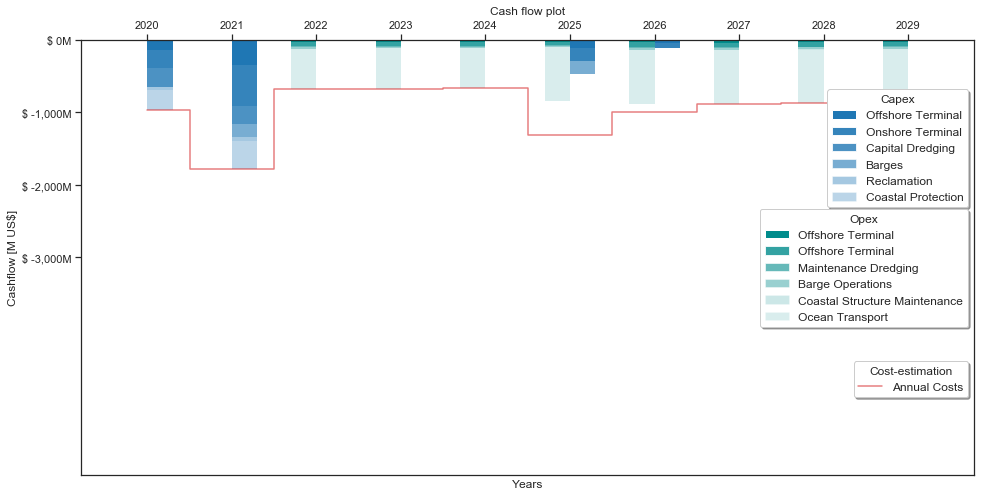

In [20]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
OffshoreBarge.cashflow_plot(cash_flows_WACC_real_df)

# save fig
# if lifecycle == 10:
#     plt.savefig("SaveFigures/cash_flow_plot_WACC_alt2.png", bbox_inches = 'tight')

In [21]:
print('Offshore land use:')

for year in range(startyear, startyear + lifecycle):
    total_land_use = OffshoreBarge.calculate_land_use(year)
    print(round(total_land_use,1),'ha')

Offshore land use:
0 ha
0 ha
320365.2 ha
320365.2 ha
320365.2 ha
320365.2 ha
425790.4 ha
455691.1 ha
455691.1 ha
455691.1 ha


list of elements
                Element         Costs
1    Coastal Protection  6.591779e+08
3        Terminal Capex  6.341509e+08
5      Capital Dredging  5.112732e+08
8      Barge Investment  3.619190e+08
4         Terminal Opex  2.585117e+08
9     Barge Operartions  1.743585e+08
6  Maintenance Dredging  1.107743e+08
0           Reclamation  1.086557e+08
2         Island maint.  2.414540e+07
7       Ocean Transport  0.000000e+00


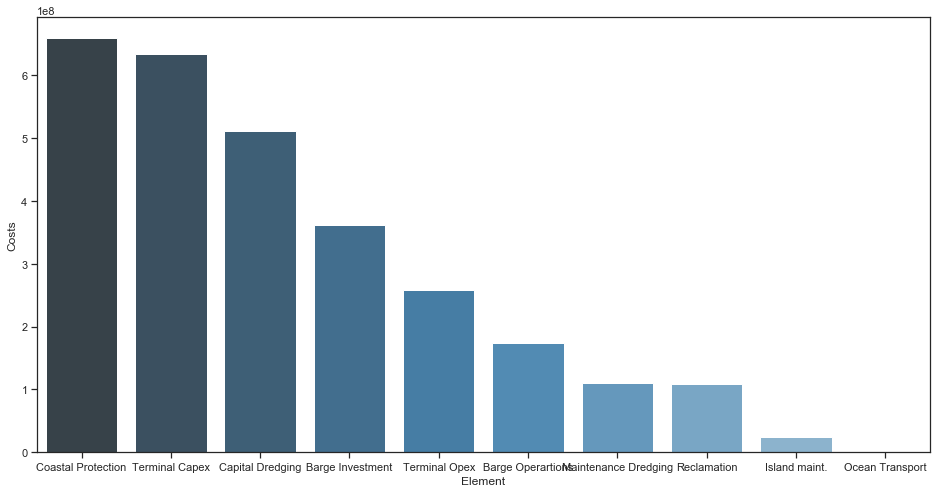

In [22]:
OffshoreBarge.element_cashflow_plot()

In [23]:
print("Offshore terminal capacity for initial demand:")
total_offshore_ground_slots, total_offshore_stack_capacity = OffshoreBarge.total_stack_capacity(2021)

total_offshore_ground_slots = round(total_offshore_ground_slots,-1)
total_offshore_stack_capacity = round(total_offshore_stack_capacity,-1)
      
%store total_offshore_ground_slots
%store total_offshore_stack_capacity

Offshore terminal capacity for initial demand:
     Total Ground Slots required (@ start of year):  3,437 TEU
     Total Stack capacity required (@ start of year):  18,197 TEU

Stored 'total_offshore_ground_slots' (float)
Stored 'total_offshore_stack_capacity' (float)


### Example figures

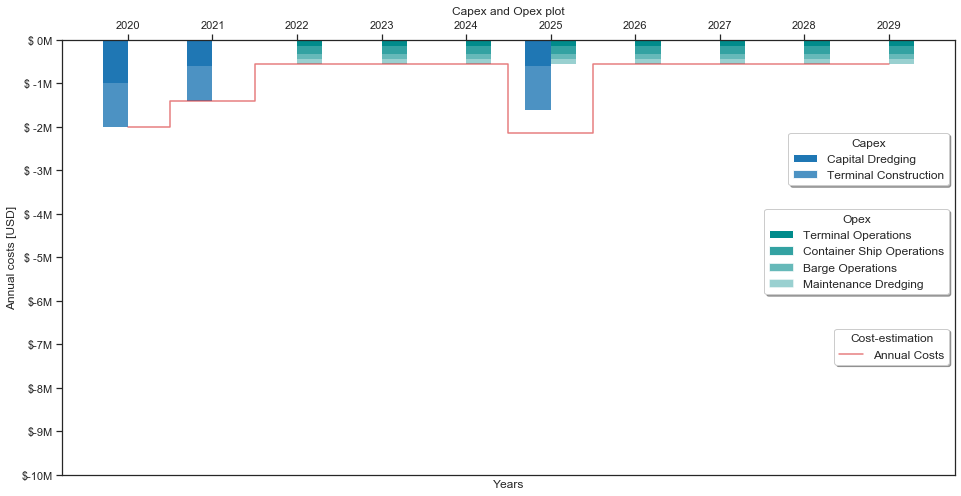

In [24]:
OffshoreBarge.ex_cashflow_plot(cash_flows_df)

# save fig
if lifecycle == 10:
    plt.savefig("SaveFigures/ex_cashflow_plot.png", bbox_inches = 'tight')

In [25]:
# store PV of the costs
demand = annual_demand.value

if offshore_distance == 40:  
    if design_container_ship == 12500:    
        if demand == 500000:
            print('The demand is 500_000')
            PV_alt2_40_12500_500000 = PV
            %store PV_alt2_40_12500_500000
        if demand == 1000000:
            print('The demand is 1_000_000')
            PV_alt2_40_12500_1000000 = PV
            %store PV_alt2_40_12500_1000000
        if demand == 1500000:
            print('The demand is 1_500_000')
            PV_alt2_40_12500_1500000 = PV
            %store PV_alt2_40_12500_1500000

The demand is 1_000_000
Stored 'PV_alt2_40_12500_1000000' (float64)


In [26]:
# store PV of the costs

if offshore_distance == 20:  
    if design_container_ship == 6000:
        PV_alt2_20_6000 = PV
        %store PV_alt2_20_6000
        
    if design_container_ship == 12500:
        PV_alt2_20_12500 = PV
        %store PV_alt2_20_12500
        
    if design_container_ship == 21000:
        PV_alt2_20_21000 = PV
        %store PV_alt2_20_21000
        
if offshore_distance == 40:  
    if design_container_ship == 6000:
        PV_alt2_40_6000 = PV
        %store PV_alt2_40_6000
        
    if design_container_ship == 12500:
        PV_alt2_40_12500 = PV
        %store PV_alt2_40_12500
        
    if design_container_ship == 21000:
        PV_alt2_40_21000 = PV
        %store PV_alt2_40_21000
        
if offshore_distance == 60:  
    if design_container_ship == 6000:
        PV_alt2_60_6000 = PV
        %store PV_alt2_60_6000
        
    if design_container_ship == 12500:
        PV_alt2_60_12500 = PV
        %store PV_alt2_60_12500
        
    if design_container_ship == 21000:
        PV_alt2_60_21000 = PV
        %store PV_alt2_60_21000

Stored 'PV_alt2_40_12500' (float64)


In [27]:
PV_alt1_40_12500_500000  = 2.3e+09
PV_alt1_40_12500_1000000 = 2.4e+09
PV_alt1_40_12500_1500000 = 2.5e+09

PV_alt2_40_12500_500000  = 2.2e+09
PV_alt2_40_12500_1000000 = 2.35e+09
PV_alt2_40_12500_1500000 = 2.65e+09

PV_alt3_40_12500_500000  = 2.15e+09
PV_alt3_40_12500_1000000 = 2.45e+09
PV_alt3_40_12500_1500000 = 2.55e+09

%store PV_alt1_40_12500_500000 
%store PV_alt1_40_12500_1000000
%store PV_alt1_40_12500_1500000

%store PV_alt2_40_12500_500000 
%store PV_alt2_40_12500_1000000
%store PV_alt2_40_12500_1500000

%store PV_alt3_40_12500_500000 
%store PV_alt3_40_12500_1000000
%store PV_alt3_40_12500_1500000

Stored 'PV_alt1_40_12500_500000' (float)
Stored 'PV_alt1_40_12500_1000000' (float)
Stored 'PV_alt1_40_12500_1500000' (float)
Stored 'PV_alt2_40_12500_500000' (float)
Stored 'PV_alt2_40_12500_1000000' (float)
Stored 'PV_alt2_40_12500_1500000' (float)
Stored 'PV_alt3_40_12500_500000' (float)
Stored 'PV_alt3_40_12500_1000000' (float)
Stored 'PV_alt3_40_12500_1500000' (float)


In [28]:
PV_alt1_40_12500_1000000_growth1 = 2.5e+09
PV_alt1_40_12500_1000000_growth2 = 2.7e+09
PV_alt1_40_12500_1000000_growth3 = 3.0e+09
PV_alt1_40_12500_1000000_growth4 = 3.7e+09

PV_alt2_40_12500_1000000_growth1 = 2.2e+09
PV_alt2_40_12500_1000000_growth2 = 3.0e+09
PV_alt2_40_12500_1000000_growth3 = 4.0e+09
PV_alt2_40_12500_1000000_growth4 = 4.8e+09

PV_alt3_40_12500_1000000_growth1 = 2.0e+09
PV_alt3_40_12500_1000000_growth2 = 3.0e+09
PV_alt3_40_12500_1000000_growth3 = 4.5e+09
PV_alt3_40_12500_1000000_growth4 = 5.8e+09

%store PV_alt1_40_12500_1000000_growth1
%store PV_alt1_40_12500_1000000_growth2
%store PV_alt1_40_12500_1000000_growth3
%store PV_alt1_40_12500_1000000_growth4

%store PV_alt2_40_12500_1000000_growth1
%store PV_alt2_40_12500_1000000_growth2
%store PV_alt2_40_12500_1000000_growth3
%store PV_alt2_40_12500_1000000_growth4

%store PV_alt3_40_12500_1000000_growth1
%store PV_alt3_40_12500_1000000_growth2
%store PV_alt3_40_12500_1000000_growth3
%store PV_alt3_40_12500_1000000_growth4

Stored 'PV_alt1_40_12500_1000000_growth1' (float)
Stored 'PV_alt1_40_12500_1000000_growth2' (float)
Stored 'PV_alt1_40_12500_1000000_growth3' (float)
Stored 'PV_alt1_40_12500_1000000_growth4' (float)
Stored 'PV_alt2_40_12500_1000000_growth1' (float)
Stored 'PV_alt2_40_12500_1000000_growth2' (float)
Stored 'PV_alt2_40_12500_1000000_growth3' (float)
Stored 'PV_alt2_40_12500_1000000_growth4' (float)
Stored 'PV_alt3_40_12500_1000000_growth1' (float)
Stored 'PV_alt3_40_12500_1000000_growth2' (float)
Stored 'PV_alt3_40_12500_1000000_growth3' (float)
Stored 'PV_alt3_40_12500_1000000_growth4' (float)


In [29]:
PV_alt1_40_12500_1000000_slope1 = 1.2e+09
PV_alt1_40_12500_1000000_slope2 = 2.8e+09
PV_alt1_40_12500_1000000_slope3 = 6.6e+09

PV_alt2_40_12500_1000000_slope1 = 2.0e+09
PV_alt2_40_12500_1000000_slope2 = 3.0e+09
PV_alt2_40_12500_1000000_slope3 = 4.5e+09

PV_alt3_40_12500_1000000_slope1 = 2.8e+09
PV_alt3_40_12500_1000000_slope2 = 3.2e+09
PV_alt3_40_12500_1000000_slope3 = 4.9e+09

%store PV_alt1_40_12500_1000000_slope1
%store PV_alt1_40_12500_1000000_slope2
%store PV_alt1_40_12500_1000000_slope3

%store PV_alt2_40_12500_1000000_slope1
%store PV_alt2_40_12500_1000000_slope2
%store PV_alt2_40_12500_1000000_slope3

%store PV_alt3_40_12500_1000000_slope1
%store PV_alt3_40_12500_1000000_slope2
%store PV_alt3_40_12500_1000000_slope3

Stored 'PV_alt1_40_12500_1000000_slope1' (float)
Stored 'PV_alt1_40_12500_1000000_slope2' (float)
Stored 'PV_alt1_40_12500_1000000_slope3' (float)
Stored 'PV_alt2_40_12500_1000000_slope1' (float)
Stored 'PV_alt2_40_12500_1000000_slope2' (float)
Stored 'PV_alt2_40_12500_1000000_slope3' (float)
Stored 'PV_alt3_40_12500_1000000_slope1' (float)
Stored 'PV_alt3_40_12500_1000000_slope2' (float)
Stored 'PV_alt3_40_12500_1000000_slope3' (float)


In [30]:
PV_alt2_40_12500_1000000_downtime0 = 2.5e+09
PV_alt2_40_12500_1000000_downtime1 = 3.1e+09
PV_alt2_40_12500_1000000_downtime2 = 4.1e+09
PV_alt2_40_12500_1000000_downtime3 = 5.2e+09
PV_alt2_40_12500_1000000_downtime4 = 7.2e+09

%store PV_alt2_40_12500_1000000_downtime0
%store PV_alt2_40_12500_1000000_downtime1
%store PV_alt2_40_12500_1000000_downtime2
%store PV_alt2_40_12500_1000000_downtime3
%store PV_alt2_40_12500_1000000_downtime4


Stored 'PV_alt2_40_12500_1000000_downtime0' (float)
Stored 'PV_alt2_40_12500_1000000_downtime1' (float)
Stored 'PV_alt2_40_12500_1000000_downtime2' (float)
Stored 'PV_alt2_40_12500_1000000_downtime3' (float)
Stored 'PV_alt2_40_12500_1000000_downtime4' (float)


In [31]:
%store -r offshore_capacity
%store -r downtime_scenario
offshore_capacity = 15_000
downtime_scenario = 1

if offshore_capacity == 10_000:
    if downtime_scenario == 1:
        PV_alt2_40_12500_1000000_downtime1_10000 = 2.1e+09
        %store PV_alt2_40_12500_1000000_downtime1_10000
    if downtime_scenario == 2:
        PV_alt2_40_12500_1000000_downtime2_10000 = 3.3e+09
        %store PV_alt2_40_12500_1000000_downtime2_10000 
    if downtime_scenario == 3:
        PV_alt2_40_12500_1000000_downtime3_10000 = 6.1e+09
        %store PV_alt2_40_12500_1000000_downtime3_10000
        
if offshore_capacity == 15_000:
    if downtime_scenario == 1:
        PV_alt2_40_12500_1000000_downtime1_15000 = 2.8e+09
        %store PV_alt2_40_12500_1000000_downtime1_15000
    if downtime_scenario == 2:
        PV_alt2_40_12500_1000000_downtime2_15000 = 3.1e+09
        %store PV_alt2_40_12500_1000000_downtime2_15000 
    if downtime_scenario == 3:
        PV_alt2_40_12500_1000000_downtime3_15000 = 4.1e+09
        %store PV_alt2_40_12500_1000000_downtime3_15000
    
if offshore_capacity == 20_000:
    if downtime_scenario == 1:
        PV_alt2_40_12500_1000000_downtime1_20000 = 4.1e+09
        %store PV_alt2_40_12500_1000000_downtime1_20000
    if downtime_scenario == 2:
        PV_alt2_40_12500_1000000_downtime2_20000 = 3.7e+09
        %store PV_alt2_40_12500_1000000_downtime2_20000 
    if downtime_scenario == 3:
        PV_alt2_40_12500_1000000_downtime3_20000 = 3.1e+09
        %store PV_alt2_40_12500_1000000_downtime3_20000
        
print(PV_alt2_40_12500_1000000_downtime1_15000)

Stored 'PV_alt2_40_12500_1000000_downtime1_15000' (float)
2800000000.0


In [32]:
# if offshore_distance == 40:  
#     if design_container_ship == 12500:
#         if barge_perc = 25:
#             PV_alt2_40_12500_1000000_hinterland1 = PV
#             %store PV_alt2_40_12500_1000000_hinterland1
            
#             PV_alt3_40_12500_1000000_hinterland3 = PV
#             %store PV_alt3_40_12500_1000000_hinterland3
            
#         if barge_perc = 50:
#             PV_alt2_40_12500_1000000_hinterland2 = PV
#             %store PV_alt2_40_12500_1000000_hinterland2
            
#             PV_alt3_40_12500_1000000_hinterland2 = PV
#             %store PV_alt3_40_12500_1000000_hinterland2

#         if barge_perc = 75:
#             PV_alt2_40_12500_1000000_hinterland3 = PV
#             %store PV_alt2_40_12500_1000000_hinterland3
            
#             PV_alt3_40_12500_1000000_hinterland1 = PV
#             %store PV_alt3_40_12500_1000000_hinterland1
            
PV_alt2_40_12500_1000000_hinterland1 = 4.5e+09  # percentage barge: 25
PV_alt2_40_12500_1000000_hinterland2 = 3.8e+09  # percentage barge: 50
PV_alt2_40_12500_1000000_hinterland3 = 2.1e+09  # percentage barge: 75

PV_alt3_40_12500_1000000_hinterland1 = 2.5e+09  # percentage barge: 75
PV_alt3_40_12500_1000000_hinterland2 = 3.6e+09  # percentage barge: 50
PV_alt3_40_12500_1000000_hinterland3 = 4.1e+09  # percentage barge: 25

%store PV_alt2_40_12500_1000000_hinterland1
%store PV_alt2_40_12500_1000000_hinterland2
%store PV_alt2_40_12500_1000000_hinterland3

%store PV_alt3_40_12500_1000000_hinterland1
%store PV_alt3_40_12500_1000000_hinterland2
%store PV_alt3_40_12500_1000000_hinterland3

Stored 'PV_alt2_40_12500_1000000_hinterland1' (float)
Stored 'PV_alt2_40_12500_1000000_hinterland2' (float)
Stored 'PV_alt2_40_12500_1000000_hinterland3' (float)
Stored 'PV_alt3_40_12500_1000000_hinterland1' (float)
Stored 'PV_alt3_40_12500_1000000_hinterland2' (float)
Stored 'PV_alt3_40_12500_1000000_hinterland3' (float)
